In [19]:
%load_ext autoreload
%autoreload 2

In [20]:
import io
import base64
import numpy as np
from pathlib import Path
import cv2
from tqdm import tqdm
import os
from keras.callbacks import EarlyStopping

from models import mdn
from models.vae import VAE
from models.rnn import RNN
import utils

import matplotlib.pyplot as plt
from matplotlib import animation, rc
%matplotlib inline

import ipywidgets as widgets
from IPython.display import HTML, Image, display, clear_output

Using TensorFlow backend.


In [3]:
rc('animation', html='html5')

## Collect images for training from Youtube

In [4]:
all_frames = []

In [5]:
frames_1 = utils.get_frames_from_youtube_video("https://www.youtube.com/watch?v=i8dh9gDzmz8", utils.frame_preprocessor)
frames_2 = utils.get_frames_from_youtube_video("https://www.youtube.com/watch?v=SUXWAEX2jlg", utils.frame_preprocessor)

[youtube] i8dh9gDzmz8: Downloading webpage
[youtube] i8dh9gDzmz8: Downloading video info webpage
[download] Destination: C:\Users\vecse\AppData\Local\Temp\tmpznx6g5jn
[download] 100% of 4.66MiB in 01:13                  
[youtube] SUXWAEX2jlg: Downloading webpage
[youtube] SUXWAEX2jlg: Downloading video info webpage
[download] Destination: C:\Users\vecse\AppData\Local\Temp\tmpg_300f3s
[download] 100% of 3.49MiB in 00:50                  


In [6]:
all_frames.extend(frames_1)
all_frames.extend(frames_2)
all_frames = np.array(all_frames)

In [7]:
all_frames.shape

(7200, 64, 64, 3)

## Train VAE

Input is (64, 64, 3) and output is 32 dim vector

In [8]:
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
IMAGE_INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

LATENT_DIM = 32

In [9]:
vae = VAE(IMAGE_INPUT_SHAPE, LATENT_DIM)

In [10]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

In [11]:
hist = vae.model.fit(all_frames,
                     all_frames,
                     batch_size=32,
                     epochs=100,
                     callbacks=[early_stopping],
                     validation_split=0.25)

Train on 5400 samples, validate on 1800 samples
Epoch 1/100
5400/5400 [==============================] - ETA: 56:52 - loss: 1486.0155 - vae_r_loss: 1485.9828 - vae_kl_loss: 0.032 - ETA: 18:47 - loss: 1478.9162 - vae_r_loss: 1478.8985 - vae_kl_loss: 0.017 - ETA: 11:10 - loss: 1481.3299 - vae_r_loss: 1481.3075 - vae_kl_loss: 0.022 - ETA: 7:54 - loss: 1449.6342 - vae_r_loss: 1449.4870 - vae_kl_loss: 0.147 - ETA: 6:05 - loss: 1440.3378 - vae_r_loss: 1439.0601 - vae_kl_loss: 1.27 - ETA: 4:56 - loss: 1420.0661 - vae_r_loss: 1418.6050 - vae_kl_loss: 1.46 - ETA: 4:08 - loss: 1385.6654 - vae_r_loss: 1384.3836 - vae_kl_loss: 1.28 - ETA: 3:33 - loss: 1345.0582 - vae_r_loss: 1343.9363 - vae_kl_loss: 1.12 - ETA: 3:06 - loss: 1329.0141 - vae_r_loss: 1328.0143 - vae_kl_loss: 0.99 - ETA: 2:45 - loss: 1296.8057 - vae_r_loss: 1295.8866 - vae_kl_loss: 0.91 - ETA: 2:27 - loss: 1276.1572 - vae_r_loss: 1275.2126 - vae_kl_loss: 0.94 - ETA: 2:13 - loss: 1257.4865 - vae_r_loss: 1256.1333 - vae_kl_loss: 1.35 - 

In [12]:
# Encode all frames in the training set
encoded_images = vae.encode(all_frames)

# Decode all previously encoded images
decoded_images = vae.decode(encoded_images, decoder_postprocessor=utils.decoded_frame_postprocessor)

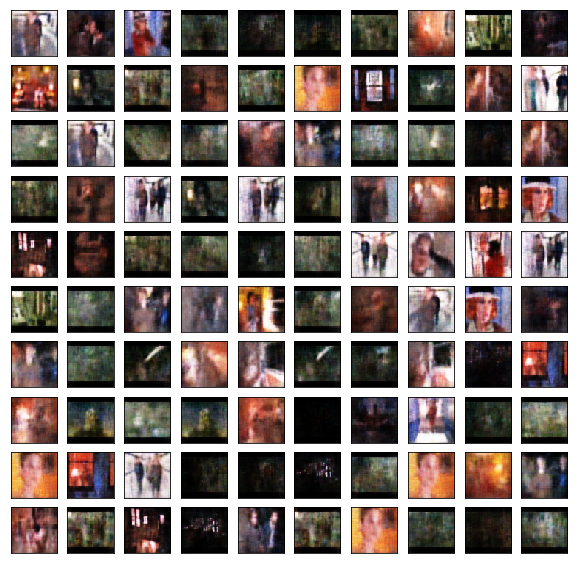

In [13]:
utils.show_image_grid(decoded_images, n_images=100, n_rows=10, randomize=True)

## Train RNN (GRU)

In [14]:
TIME_STEPS = 10

In [15]:
x_rnn_data, y_rnn_data = utils.create_rnn_data(encoded_images, TIME_STEPS)

In [16]:
rnn = RNN(LATENT_DIM, LATENT_DIM, TIME_STEPS, contain_mdn_layer=True)

In [17]:
hist = rnn.model.fit(x_rnn_data,
                     y_rnn_data,
                     epochs=100,
                     batch_size=32,
                     callbacks=[early_stopping])

Epoch 1/100
7168/7190 [============================>.] - ETA: 7:35 - loss: 46.5985 - acc: 0.0000e+ - ETA: 3:52 - loss: 45.8634 - acc: 0.0000e+ - ETA: 2:38 - loss: 45.9954 - acc: 0.0000e+ - ETA: 1:38 - loss: 45.8317 - acc: 0.0000e+ - ETA: 1:23 - loss: 45.8416 - acc: 0.0000e+ - ETA: 1:12 - loss: 45.7553 - acc: 0.0000e+ - ETA: 58s - loss: 45.7188 - acc: 0.0000e+00 - ETA: 49s - loss: 45.6532 - acc: 0.0000e+0 - ETA: 42s - loss: 45.6705 - acc: 0.0000e+0 - ETA: 40s - loss: 45.5416 - acc: 0.0000e+0 - ETA: 36s - loss: 45.4728 - acc: 0.0000e+0 - ETA: 33s - loss: 45.4931 - acc: 0.0000e+0 - ETA: 30s - loss: 45.2584 - acc: 0.0000e+0 - ETA: 29s - loss: 45.2166 - acc: 0.0000e+0 - ETA: 28s - loss: 45.1518 - acc: 0.0000e+0 - ETA: 27s - loss: 45.0610 - acc: 0.0000e+0 - ETA: 25s - loss: 44.9940 - acc: 0.0000e+0 - ETA: 25s - loss: 44.9545 - acc: 0.0000e+0 - ETA: 23s - loss: 44.7976 - acc: 0.0000e+0 - ETA: 22s - loss: 44.7377 - acc: 0.0000e+0 - ETA: 21s - loss: 44.6182 - acc: 0.0000e+0 - ETA: 20s - loss: 4

c:\users\vecse\anaconda3\envs\kaggle\lib\site-packages\keras\callbacks.py:494: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


7190/7190 [==============================] - 14s 2ms/step - loss: 37.9337 - acc: 0.0025
Epoch 2/100
7190/7190 [==============================] - ETA: 10s - loss: 32.7024 - acc: 0.0000e+0 - ETA: 11s - loss: 32.9961 - acc: 0.0000e+0 - ETA: 11s - loss: 32.5029 - acc: 0.0000e+0 - ETA: 11s - loss: 32.5578 - acc: 0.0000e+0 - ETA: 11s - loss: 32.7982 - acc: 0.0063    - ETA: 10s - loss: 32.8862 - acc: 0.004 - ETA: 11s - loss: 32.7135 - acc: 0.003 - ETA: 10s - loss: 32.8701 - acc: 0.003 - ETA: 10s - loss: 32.7068 - acc: 0.002 - ETA: 10s - loss: 32.5407 - acc: 0.002 - ETA: 10s - loss: 32.5804 - acc: 0.002 - ETA: 10s - loss: 32.6246 - acc: 0.001 - ETA: 10s - loss: 32.6542 - acc: 0.001 - ETA: 10s - loss: 32.6631 - acc: 0.003 - ETA: 9s - loss: 32.7167 - acc: 0.003 - ETA: 9s - loss: 32.7267 - acc: 0.00 - ETA: 9s - loss: 32.6682 - acc: 0.00 - ETA: 9s - loss: 32.5659 - acc: 0.00 - ETA: 9s - loss: 32.5369 - acc: 0.00 - ETA: 9s - loss: 32.5161 - acc: 0.00 - ETA: 9s - loss: 32.3801 - acc: 0.00 - ETA: 9s 

## Generate new images

In [18]:
starter_frames = np.random.randint(0, 255, (TIME_STEPS, ) + IMAGE_INPUT_SHAPE, dtype=np.uint8)
encoded_starter_frames = vae.encode(starter_frames)

In [19]:
N_IMAGES_TO_GENERATE = 150
generated_encoded_frames = encoded_starter_frames.copy()

for i in range(N_IMAGES_TO_GENERATE):
    next_encoded_frame = rnn.predict(np.expand_dims(generated_encoded_frames[i:i + TIME_STEPS], axis=0))[0]
    generated_encoded_frames = np.vstack((generated_encoded_frames, next_encoded_frame))

In [20]:
generated_encoded_frames.shape

(160, 32)

In [21]:
generated_decoded_frames = vae.decode(generated_encoded_frames, decoder_postprocessor=utils.decoded_frame_postprocessor)

In [22]:
generated_decoded_frames.shape

(160, 64, 64, 3)

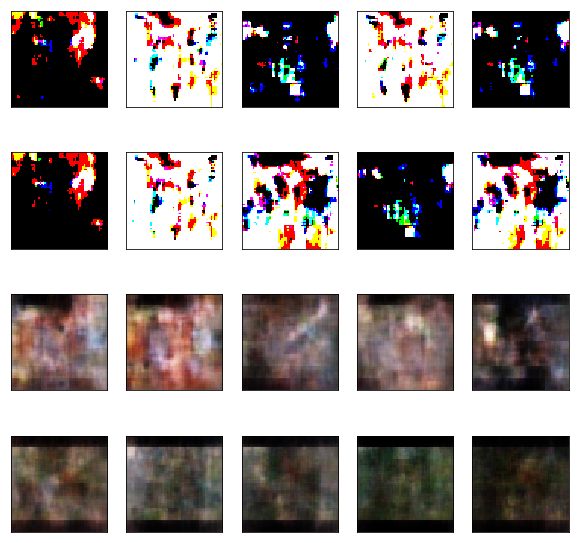

In [23]:
utils.show_image_grid(generated_decoded_frames, n_images=20, n_rows=4, randomize=False)

## Results

### Visualize VAE results on training set

In [24]:
from_index = 0
to_index = 1000

fig = plt.figure(figsize=(5, 3))

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Original")
ax1.set_xticks([])
ax1.set_yticks([])
img1 = ax1.imshow(all_frames[0])

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("VAE Encoded then Decoded")
ax2.set_xticks([])
ax2.set_yticks([])
img2 = ax2.imshow(decoded_images[0])
plt.close()

def animate(index_of_frame):
    if index_of_frame % 200 == 0 and index_of_frame != 0:
        print("Done with {0} frames".format(index_of_frame))
    img1.set_data(all_frames[from_index:to_index][index_of_frame])
    img2.set_data(decoded_images[from_index:to_index][index_of_frame])
    return (img1, img2,)

anim = animation.FuncAnimation(fig, animate, frames=(to_index-from_index-1), interval=41, blit=True)

animation_file_path = "./art/vae_decoded_vs_original.mp4"
anim.save(animation_file_path, writer='ffmpeg', fps=24)
utils.convert_video_to_gif(animation_file_path, Path(animation_file_path).with_suffix(".gif"))

Done with 200 frames
Done with 400 frames
Done with 600 frames
Done with 800 frames


In [25]:
video = io.open(animation_file_path, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
            <video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>
          '''.format(encoded.decode('ascii')))

### Interactive VAE decode

In this section we can construct our own latent-space vector which can be then decoded.

That way we can experience which feature controls how much should the image change.

In [26]:
test_encoded_image = encoded_images[500].copy()
sliders = [widgets.FloatSlider(description=str(i), min=-3, max=3, step=0.001, continuous_update=False, value=x)
           for i, x in enumerate(test_encoded_image)]

out = widgets.Output()

def vae_test_decode(change):
    test_encoded_image = [s.value for s in sliders]
    decoded_image = vae.decode(np.expand_dims(test_encoded_image, 0), decoder_postprocessor=utils.decoded_frame_postprocessor)[0]
    with out:
        clear_output(wait=True)
        fig = plt.figure()
        plt.title("Decoded image")
        plt.imshow(decoded_image)
        plt.show()

for s in sliders:
    s.observe(vae_test_decode, "value")

slider_columns = [widgets.VBox(tuple(x)) for x in np.array_split(sliders, 3)]
slider_columns.append(out)
hbox = widgets.HBox(slider_columns)
display(hbox)

### Visualize Generated Image Sequence

In [27]:
fig = plt.figure(figsize=(5, 5))

ax1 = fig.add_subplot(1, 1, 1)
ax1.set_title("Generated with VAE and RNN")
ax1.set_xticks([])
ax1.set_yticks([])
img1 = ax1.imshow(generated_decoded_frames[0])
plt.close()

def animate(index_of_frame):
    if index_of_frame % 200 == 0 and index_of_frame != 0:
        print("Done with {0} frames".format(index_of_frame))
    img1.set_data(generated_decoded_frames[index_of_frame])
    return (img1,)

anim = animation.FuncAnimation(fig, animate, frames=len(generated_decoded_frames), interval=41, blit=True)

generated_animation_file_path = "./art/generated_image_sequence.mp4"    
anim.save(generated_animation_file_path, writer='ffmpeg', fps=24)
utils.convert_video_to_gif(generated_animation_file_path, Path(generated_animation_file_path).with_suffix(".gif"))

In [28]:
video = io.open(generated_animation_file_path, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
            <video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>
          '''.format(encoded.decode('ascii')))